In [5]:
from mmflow.apis import init_model, inference_model
from mmflow.datasets import visualize_flow, write_flow
from mmflow.models.utils import occlusion_estimation
import mmcv
import torch
import _init_paths
import numpy as np
import matplotlib.pyplot as plt
from vcl.utils import *
from vcl.models.trackers import *
from mmcv.ops import Correlation

from vcl.models.common import non_local_attention
%matplotlib inline

2022-04-26 21:42:10,050 - vcl - INFO - Loading /home/lr/models/ssl/image_based/detco_200ep_AA.pth as torchvision


load checkpoint from local path: /home/lr/models/ssl/image_based/detco_200ep_AA.pth


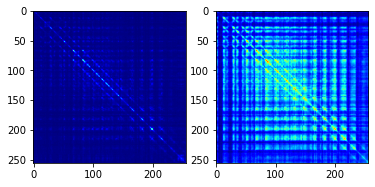

In [6]:
ckpt = '/home/lr/models/epoch_3200.pth'
state_dict = torch.load(ckpt)['state_dict']

model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 2, 2), out_indices=(3, ), pool_type='none'),
    test_cfg=dict(),
    train_cfg=dict()
    ).cuda()
model.load_state_dict(state_dict=state_dict, strict=False)

model_t = VanillaTracker(
    backbone=dict(type='ResNet', depth=50, strides=(1, 2, 1, 2), out_indices=(3, ), pretrained='/home/lr/models/ssl/image_based/detco_200ep_AA.pth'),
    test_cfg=dict(),
    train_cfg=dict()
    ).cuda()




feat_size = [64, 32]
radius = [12, 6]
mask = [ make_mask(feat_size[i], radius[i]) for i in range(len(radius))]  
corrs = [ Correlation(max_displacement=R) for R in radius]


# test image pair, and save the results
img1='/home/lr/dataset/YouTube-VOS/2018/train_all_frames/JPEGImages/1acd0f993b/00120.jpg'
img2='/home/lr/dataset/YouTube-VOS/2018/train_all_frames/JPEGImages/1acd0f993b/00123.jpg'


img1= mmcv.imresize(mmcv.imread(img1), (256,256))
img2 = mmcv.imresize(mmcv.imread(img1), (256,256))
x1_r = preprocess_(img1, mode='rgb').cuda()
x2_r = preprocess_(img2, mode='rgb').cuda()
x1 = preprocess_(img1, mode='rgb').cuda()
x2 = preprocess_(img2, mode='rgb').cuda()




def visual_local_corr():
    fs1 = model.backbone(x1)
    fs2 = model.backbone(x2)
    corr1 = corrs[0](fs1[0], fs2[0]).flatten(-2).flatten(1,2)
    corr2 = corrs[1](fs1[1], fs2[1]).flatten(-2).flatten(1,2)

    corr1 = np.array(corr1[0].detach().cpu())
    corr2 = np.array(corr2[0].detach().cpu())

    corr1 = mmcv.imresize(corr1, (2000, 4000))
    corr2 = mmcv.imresize(corr2, (500, 1000))


    # corr1 = non_local_attention(fs1[0], fs2[0][:,None], att_only=True, mask=mask[0])
    # corr2 = non_local_attention(fs1[1], fs2[1][:,None], att_only=True, mask=mask[1])
    # corr1 = np.array(corr1[0][0].detach().cpu())
    # corr2 = np.array(corr2[0][0].detach().cpu())

    plt.figure()
    plt.subplot(1,2,1), plt.imshow(corr1,cmap=plt.get_cmap('jet'))
    plt.subplot(1,2,2), plt.imshow(corr2,cmap=plt.get_cmap('jet'))

    corr1 = color_map(corr1, norm=True)
    corr2 = color_map(corr2, norm=True)

    mmcv.imwrite(corr1, 'corr1.jpg')
    mmcv.imwrite(corr2, 'corr2.jpg')

def visual_global_corr(x1, x2):
    fs1 = model_t.backbone(x1)
    fs2 = model_t.backbone(x2)
    corr1 = non_local_attention(fs1, fs2[:,None], att_only=True)
    corr1 = np.array(corr1[0][0].detach().cpu())[131, :].reshape(16,16)
    corr1 = mmcv.imresize(corr1, (256,256))
    
    
    plt.figure()
    plt.subplot(1,2,1), plt.imshow(corr1,cmap=plt.get_cmap('jet'))
    plt.subplot(1,2,2), plt.imshow(img2)
    
    corr1 = show_cam_on_image(img2, corr1)
    mmcv.imwrite(corr1, 'global_corr.jpg')
    
def visual_global_corr_2():
    fs1 = model_t.backbone(x1_r)
    fs2 = model_t.backbone(x2_r)
    corr1 = non_local_attention(fs1, fs2[:,None], att_only=True)
    corr1 = np.array(corr1[0][0].detach().cpu()).reshape(256,256)
    corr1 = mmcv.imresize(corr1, (256,256))
    
    plt.figure()
    plt.subplot(1,2,1), plt.imshow(corr1,cmap=plt.get_cmap('jet'))
    # plt.subplot(1,2,2), plt.imshow(img2)
    corr1 = color_map(corr1, norm=True)
    mmcv.imwrite(corr1, 'global_corr.jpg')


    
    fs1 = model.backbone(x1)
    fs2 = model.backbone(x2)
    corr1 = non_local_attention(fs1, fs2[:,None], att_only=True)
    corr1 = np.array(corr1[0][0].detach().cpu()).reshape(256,256)
    corr1 = mmcv.imresize(corr1, (256,256))
    plt.subplot(1,2,2), plt.imshow(corr1,cmap=plt.get_cmap('jet'))
    corr1 = color_map(corr1, norm=True)
    mmcv.imwrite(corr1, 'global_corr_s.jpg')


visual_global_corr_2()


